# Import Libraries

In [94]:
import os

import pandas as pd #used for data manipulation and analysis
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt #used for plotting
import seaborn as sns #used for plotting

from keras import callbacks, metrics, initializers, optimizers 
from keras.models import Sequential #used for model building
from keras.layers import Dense #used for creating layers

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score #import confusion matrix
from sklearn.metrics import roc_curve, precision_recall_curve #import ROC curve tools
from sklearn.model_selection import train_test_split #used for splitting data into training and testing sets
import joblib #used for saving and loading models

from eli5.PermutationImportance import get_score_importances

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Set Up

In [2]:
mpl.rcParams['figure.figsize'] = (10,8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(42)

# Data Preprocessing

## Load Data

In [3]:
# function to load x
def load_x(data_path):
    df_x = pd.read_csv(data_path)
    # return the 7th and the second last column of the test data
    df_x = df_x.iloc[:,7:-1]
    # fill the missing data with the mean of the column
    df_x.loc[df_x['median_hs_income']=='**', 'median_hs_income'] = np.nan
    df_x['median_hs_income'] = df_x['median_hs_income'].astype(float)
    columns = [x for x in df_x.columns]
    impute = KNNImputer()
    df_x = impute.fit_transform(df_x)
    df_x = pd.DataFrame(df_x,columns=columns)
    return df_x


# function to load y
def load_y(data_path):
    df_y = pd.read_csv(data_path)
    df_y = df_y.iloc[:,-1]
    # fill the missing data with the mode of the column
    df_y = df_y.fillna(df_y.mode())
    return df_y



## Set Data Path

In [4]:
# set the work directory to the project directory
path = 'G:\\HSUHK\\COM6101\\project\\RL.csv'
save_path = 'G:\\HSUHK\\COM6101\\project\\model-training-result'

In [5]:
# load the data
x = load_x(path)
y = load_y(path)

## Describe the Data

In [6]:
feature_name = x.columns

In [7]:
x.describe().T


,count,mean,std,min,25%,50%,75%,max
number_of_nearby_restaurants,14067.0,35.157532,31.066114,0.000000,13.000000,27.000000,47.000000,176.000000
number_of_bus_stops,14067.0,0.687709,1.208915,0.000000,0.000000,0.000000,1.000000,8.000000
number_of_MTR_stations,14067.0,0.687069,1.696310,0.000000,0.000000,0.000000,0.000000,13.000000
number_of_schools,14067.0,1.124547,1.837447,0.000000,0.000000,0.000000,2.000000,17.000000
number_of_commercial_facilities,14067.0,2.316272,2.442425,0.000000,0.000000,2.000000,4.000000,20.000000
number_of_government_facilities,14067.0,1.215682,1.810589,0.000000,0.000000,1.000000,2.000000,23.000000
number_of_religious_facilities,14067.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
number_of_medical_facilities,14067.0,0.670363,1.329014,0.000000,0.000000,0.000000,1.000000,13.000000
number_of_hotel_facilities,14067.0,4.310230,19.731595,0.000000,0.000000,0.000000,2.000000,383.000000
mean_median_age,14067.0,44.228257,6.289422,32.786490,38.290918,40.003538,50.488131,66.700707


In [8]:
neg, pos = np.bincount(y)
total = y.shape[0]
print(f"Total: {total}\n\
Positive: {pos}({(pos/total)*100:.4f}% of total)")


Total: 14067
Positive: 12363(87.8865% of total)


## Normalization

In [9]:
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)

## Split the Data

In [10]:
# split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaler, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,random_state=42)


# Define the Model and Metrics

In [11]:
METRICS =  [metrics.TruePositives(name='tp'),metrics.FalsePositives(name='fp'),
            metrics.TrueNegatives(name='tn'),metrics.FalseNegatives(name='fn'),
            metrics.BinaryAccuracy(name='accuracy'),metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),metrics.AUC(name='auc'),
            metrics.AUC(name='prc',curve='PR')]

# Define the neural network function
def ANN_model(neurons=34, learning_rate=0.05, momentum=0.1, weight_decay=0.0, nesterov=True, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    # Define the model architecture
    model = Sequential()
    # Add the first hidden layer
    model.add(Dense(neurons, input_dim=x.shape[1], activation='relu', kernel_initializer='he_normal'))
    # Add the second hidden layer
    model.add(Dense(neurons, activation='relu', kernel_initializer='glorot_uniform'))
    # Add the third hidden layer
    model.add(Dense(neurons, activation='relu', kernel_initializer='he_normal'))
    # Add the output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',bias_initializer=output_bias))
    # specify the optimizer
    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay)
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    return model


# Baseline Model

In [12]:
EPOCHS = 500
BATCH_SIZE = 8

callback = callbacks.EarlyStopping(monitor='val_auc',patience=5,mode='max',restore_best_weights=True)

## Model Summary

In [13]:
model = ANN_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 34)                612       
                                                                 
 dense_1 (Dense)             (None, 34)                1190      
                                                                 
 dense_2 (Dense)             (None, 34)                1190      
                                                                 
 dense_3 (Dense)             (None, 1)                 35        
                                                                 
Total params: 3027 (11.82 KB)
Trainable params: 3027 (11.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Set the correct initial bias

In [14]:
model.predict(x_train[:10])

1/1 [==============================] - 0s 87ms/step


array([[0.3126548 ],
       [0.36207774],
       [0.45424816],
       [0.48012295],
       [0.5276331 ],
       [0.6027904 ],
       [0.37119704],
       [0.4075863 ],
       [0.52850795],
       [0.42735723]], dtype=float32)

In [15]:
results = model.evaluate(x_train,y_train,batch_size=BATCH_SIZE,verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.7307


## Initial bias

In [16]:
p0 = pos/(neg+pos)
initial_bias = np.log([pos/neg])
initial_bias

array([1.98172971])

In [17]:
model = ANN_model(output_bias=initial_bias)
model.predict(x_train[:10])


1/1 [==============================] - 0s 54ms/step


array([[0.9658386 ],
       [0.9449947 ],
       [0.93549347],
       [0.72823757],
       [0.8421941 ],
       [0.9443176 ],
       [0.9952536 ],
       [0.9620027 ],
       [0.97395104],
       [0.9709912 ]], dtype=float32)

In [18]:
results = model.evaluate(x_train,y_train,batch_size=BATCH_SIZE,verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4310


## Checkpoint the initial weights

In [19]:
initial_weights = os.path.join(save_path, './initial_weights')
model.save_weights(initial_weights)

## Confirm that the bias fix helps

In [20]:
model = ANN_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback],validation_data=(x_val,y_val),verbose=1)


Epoch 1/500
1126/1126 [==============================] - 2s 1ms/step - loss: 0.3743 - tp: 19221.0000 - fp: 2582.0000 - tn: 643.0000 - fn: 4560.0000 - accuracy: 0.7355 - precision: 0.8816 - recall: 0.8083 - auc: 0.5085 - prc: 0.8828 - val_loss: 0.3783 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5402 - val_prc: 0.8897
Epoch 2/500
1126/1126 [==============================] - 1s 991us/step - loss: 0.3623 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8806 - precision: 0.8806 - recall: 1.0000 - auc: 0.5796 - prc: 0.9099 - val_loss: 0.3758 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5486 - val_prc: 0.8956
Epoch 3/500
1126/1126 [==============================] - 1s 1ms/step - loss: 0.3581 - tp: 7927.0000 - fp: 1075.0000 - tn: 0

In [21]:
model = ANN_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback],validation_data=(x_val,y_val),verbose=1)

Epoch 1/500
1126/1126 [==============================] - 2s 1ms/step - loss: 0.3676 - tp: 9896.0000 - fp: 1354.0000 - tn: 1.0000 - fn: 2.0000 - accuracy: 0.8795 - precision: 0.8796 - recall: 0.9998 - auc: 0.5461 - prc: 0.8959 - val_loss: 0.3723 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5778 - val_prc: 0.9025
Epoch 2/500
1126/1126 [==============================] - 1s 1ms/step - loss: 0.3599 - tp: 7926.0000 - fp: 1075.0000 - tn: 0.0000e+00 - fn: 1.0000 - accuracy: 0.8805 - precision: 0.8806 - recall: 0.9999 - auc: 0.5917 - prc: 0.9138 - val_loss: 0.3760 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5576 - val_prc: 0.8971
Epoch 3/500
1126/1126 [==============================] - 1s 951us/step - loss: 0.3579 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000e+00 -

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.plot(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.plot(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

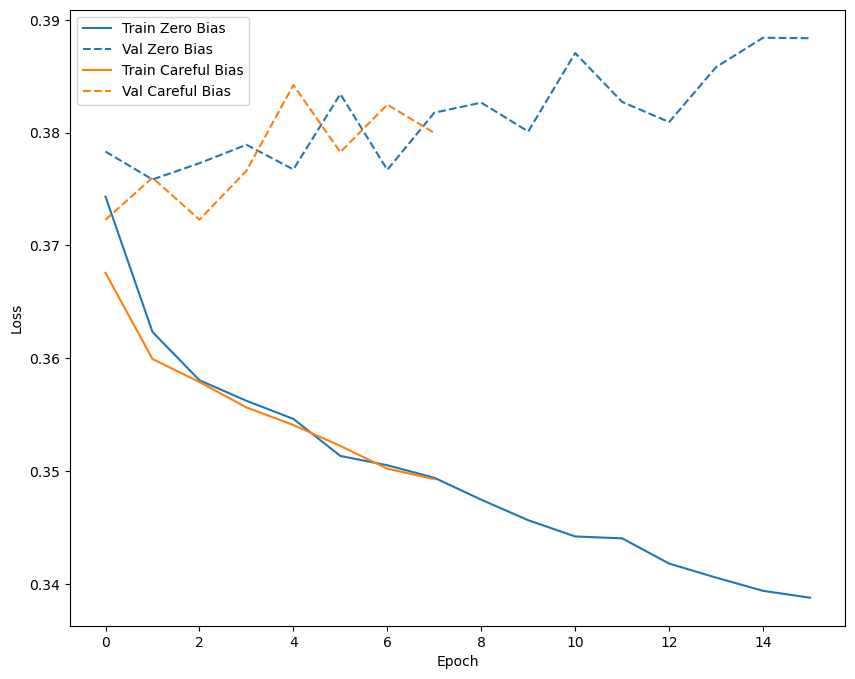

In [23]:
plot_loss(zero_bias_history,'Zero Bias',0)
plot_loss(careful_bias_history,'Careful Bias',1)

## Train the model

In [24]:
model = ANN_model()
model.load_weights(initial_weights)
baseline_history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[callback],validation_data=(x_val,y_val),verbose=1)


Epoch 1/500
1126/1126 [==============================] - 3s 1ms/step - loss: 0.3668 - tp: 9895.0000 - fp: 1355.0000 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.8793 - precision: 0.8796 - recall: 0.9997 - auc: 0.5480 - prc: 0.8974 - val_loss: 0.3741 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5623 - val_prc: 0.8980
Epoch 2/500
1126/1126 [==============================] - 1s 1ms/step - loss: 0.3613 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.8806 - precision: 0.8806 - recall: 1.0000 - auc: 0.5802 - prc: 0.9094 - val_loss: 0.3747 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5658 - val_prc: 0.8989
Epoch 3/500
1126/1126 [==============================] - 1s 996us/step - loss: 0.3585 - tp: 7927.0000 - fp: 1075.0000 - tn: 0.00

## Check training history

In [25]:
def plot_metrics(history):
  metrics=['loss','accuracy','precision','recall','prc','auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.subplots_adjust(wspace=0.5,hspace=0.5)

    if metric in ['precision','auc','accuracy','prc'] :
      plt.ylim([0.50,plt.ylim()[1]])
    elif metric=='loss':
      plt.ylim([0.3,plt.ylim()[1]])
    else:
      plt.ylim([plt.ylim()[0],plt.ylim()[1]])

  plt.show()

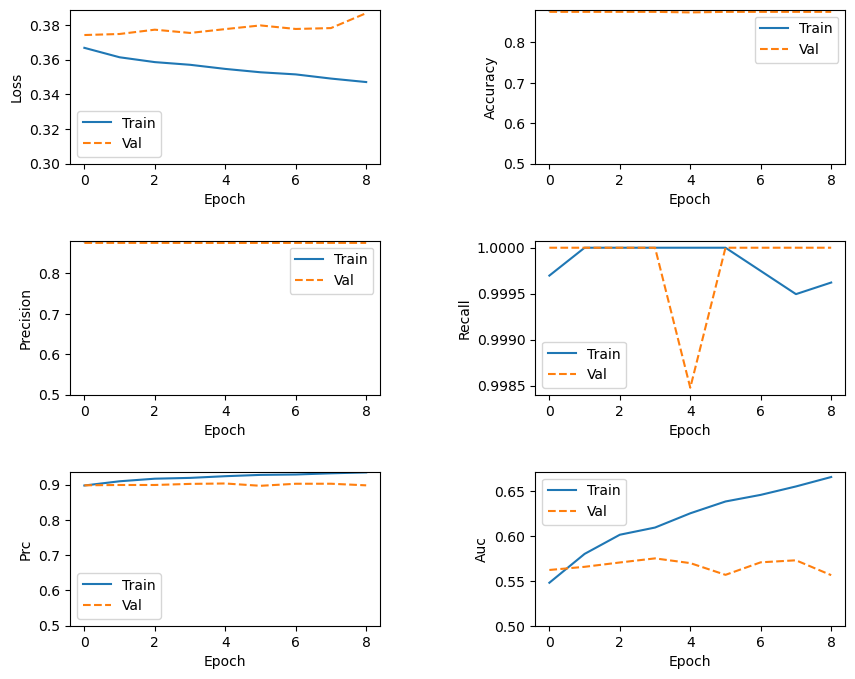

In [26]:
plot_metrics(baseline_history)

## Evaluate metrics

In [27]:
train_predictions_baseline = model.predict(x_train,batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(x_test,batch_size=BATCH_SIZE)

352/352 [==============================] - 0s 560us/step


In [28]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.37680894136428833
tp :  2465.0
fp :  349.0
tn :  0.0
fn :  0.0
accuracy :  0.8759772777557373
precision :  0.8759772777557373
recall :  1.0
auc :  0.5542738437652588
prc :  0.8952875137329102

Legitimate Transactions Detected (True Negatives):  0
Legitimate Transactions Incorrectly Detected (False Positives):  349
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  2465
Total Fraudulent Transactions:  2465


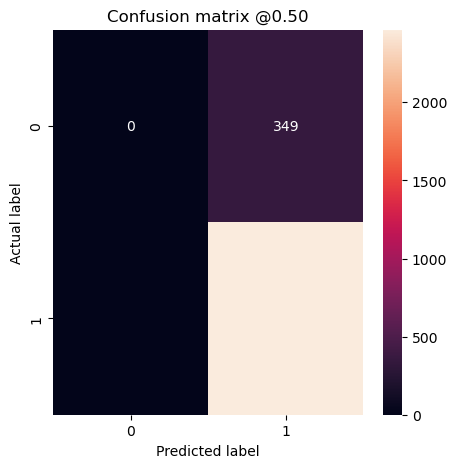

In [29]:
baseline_results = model.evaluate(x_test,y_test,batch_size=BATCH_SIZE,verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

## Plot the ROC

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim()
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

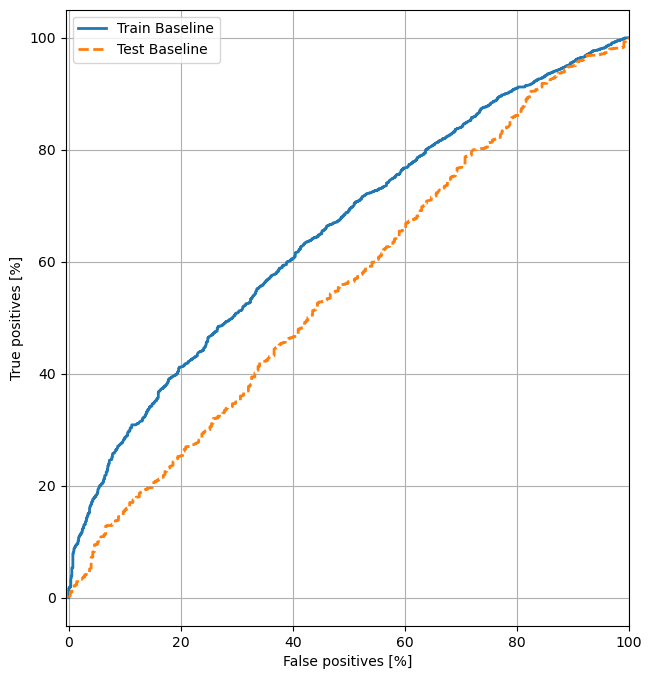

In [31]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend()

## Plot the PRC

In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlim([-0.05,1.0])
    plt.ylim([-0.05,1.0])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

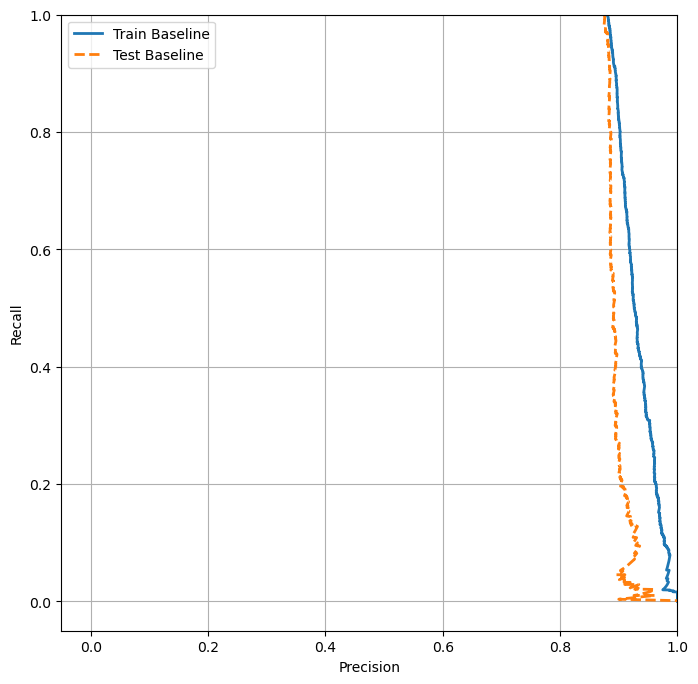

In [33]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend()

# Class weights

## calculate class weights

In [34]:
# weight_for_0 = (1/neg)*(total/2.0)
# weight_for_1 = (1/pos)*(total/2.0)
weight_for_0 = 2.0
weight_for_1 = 0.5

class_weight = {0:weight_for_0,1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 2.00
Weight for class 1: 0.50


## Train a model with class weights

In [35]:
weighted_model = ANN_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(x_train,y_train,epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,callbacks=[callback],
                                      validation_data=(x_val,y_val),
                                      class_weight=class_weight,verbose=1)

Epoch 1/500
1126/1126 [==============================] - 3s 1ms/step - loss: 0.4487 - tp: 10006.0000 - fp: 1359.0000 - tn: 65.0000 - fn: 386.0000 - accuracy: 0.8523 - precision: 0.8804 - recall: 0.9629 - auc: 0.5264 - prc: 0.8884 - val_loss: 0.4441 - val_tp: 1971.0000 - val_fp: 280.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.8756 - val_recall: 1.0000 - val_auc: 0.5525 - val_prc: 0.8972
Epoch 2/500
1126/1126 [==============================] - 1s 1ms/step - loss: 0.4348 - tp: 7736.0000 - fp: 1033.0000 - tn: 42.0000 - fn: 191.0000 - accuracy: 0.8640 - precision: 0.8822 - recall: 0.9759 - auc: 0.5760 - prc: 0.9093 - val_loss: 0.5472 - val_tp: 1786.0000 - val_fp: 255.0000 - val_tn: 25.0000 - val_fn: 185.0000 - val_accuracy: 0.8045 - val_precision: 0.8751 - val_recall: 0.9061 - val_auc: 0.5441 - val_prc: 0.8951
Epoch 3/500
1126/1126 [==============================] - 1s 1ms/step - loss: 0.4293 - tp: 7652.0000 - fp: 1019.0000 - tn: 56.0000 - fn: 27

## Check training history

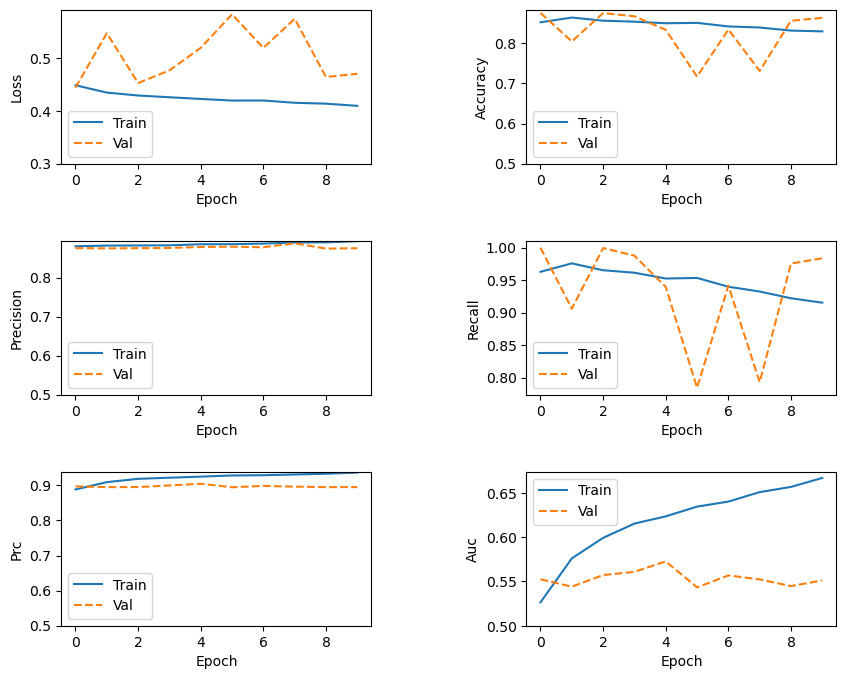

In [36]:
plot_metrics(weighted_history)

## Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(x_train,batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test,batch_size=BATCH_SIZE)

352/352 [==============================] - 0s 542us/step


loss :  0.527407705783844
tp :  2322.0
fp :  316.0
tn :  33.0
fn :  143.0
accuracy :  0.836887001991272
precision :  0.8802123069763184
recall :  0.9419878125190735
auc :  0.5543797016143799
prc :  0.8965396881103516

Legitimate Transactions Detected (True Negatives):  33
Legitimate Transactions Incorrectly Detected (False Positives):  316
Fraudulent Transactions Missed (False Negatives):  143
Fraudulent Transactions Detected (True Positives):  2322
Total Fraudulent Transactions:  2465


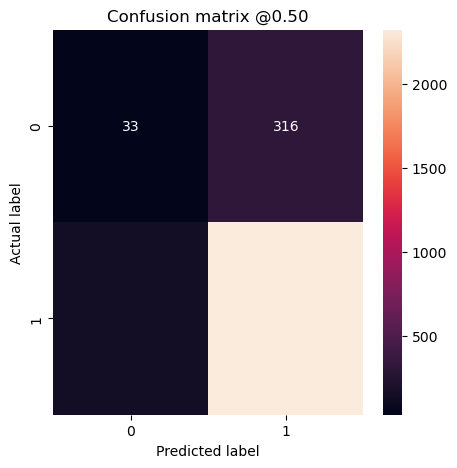

In [38]:
weighted_results = weighted_model.evaluate(x_test,y_test,batch_size=BATCH_SIZE,verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

## Plot the ROC

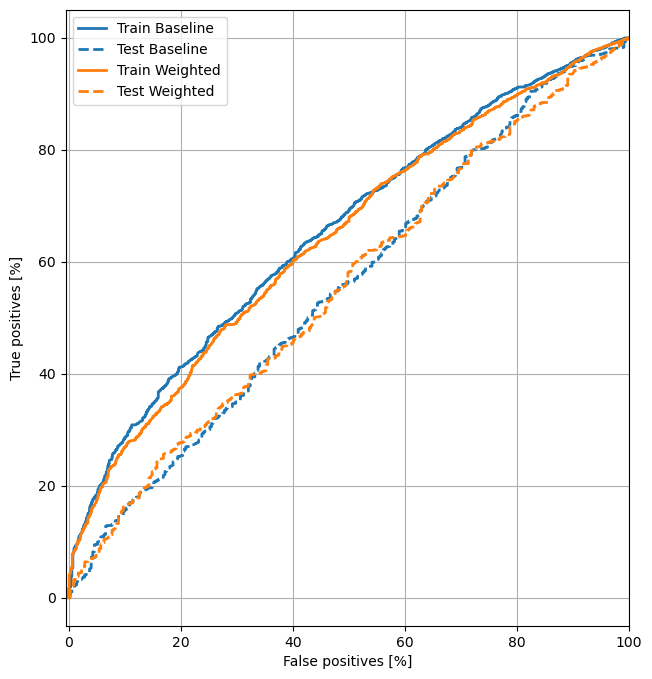

In [39]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend()

## Plot the PRC

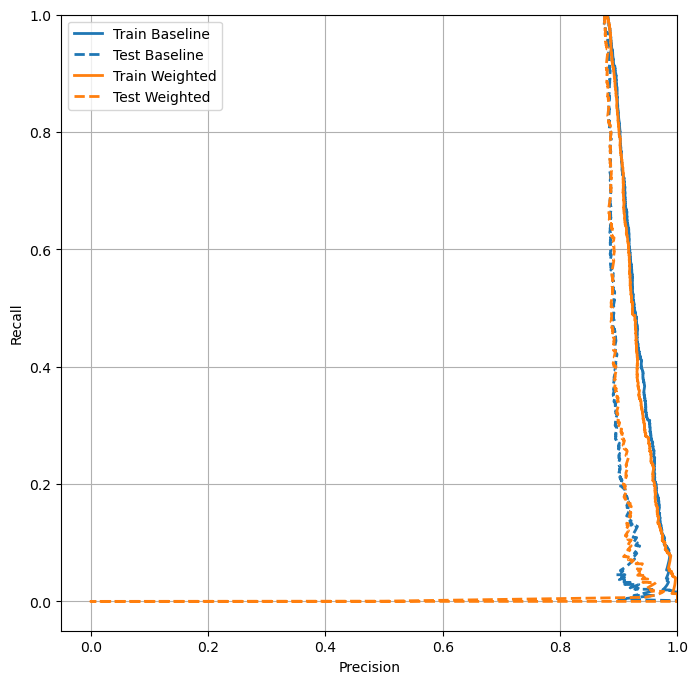

In [40]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend()

# Oversampling

## oversample the minority class

In [41]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_scaler, y)


In [42]:
x_resampled = pd.DataFrame(x_resampled,columns=feature_name)

## check the distribution

In [43]:
y_resampled.value_counts()

survive
1    12363
0    12363
Name: count, dtype: int64

## split the data

In [44]:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(x_resampled,y_resampled,test_size=0.2,random_state=42)
x_train_resampled, x_val_resampled, y_train_resampled, y_val_resampled = train_test_split(x_train_resampled,y_train_resampled,test_size=0.2,random_state=42)

## Train on the oversampled data

In [45]:
resampled_model = ANN_model()
resampled_model.load_weights(initial_weights)
# reset the bias to zero, since the dataset is balanced
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 34)                612       
                                                                 
 dense_25 (Dense)            (None, 34)                1190      
                                                                 
 dense_26 (Dense)            (None, 34)                1190      
                                                                 
 dense_27 (Dense)            (None, 1)                 35        
                                                                 
Total params: 3027 (11.82 KB)
Trainable params: 3027 (11.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
resampled_history = resampled_model.fit(x_train_resampled,y_train_resampled,epochs=EPOCHS,
                              batch_size=BATCH_SIZE,verbose=1,
                              callbacks=[callback],validation_data=(x_val_resampled,y_val_resampled))

Epoch 1/500
1978/1978 [==============================] - 3s 1ms/step - loss: 0.6760 - tp: 6561.0000 - fp: 3412.0000 - tn: 4795.0000 - fn: 3870.0000 - accuracy: 0.6093 - precision: 0.6579 - recall: 0.6290 - auc: 0.6502 - prc: 0.7090 - val_loss: 0.6540 - val_tp: 854.0000 - val_fp: 410.0000 - val_tn: 1578.0000 - val_fn: 1114.0000 - val_accuracy: 0.6148 - val_precision: 0.6756 - val_recall: 0.4339 - val_auc: 0.6595 - val_prc: 0.6727
Epoch 2/500
1978/1978 [==============================] - 2s 943us/step - loss: 0.6524 - tp: 4325.0000 - fp: 2587.0000 - tn: 5271.0000 - fn: 3641.0000 - accuracy: 0.6064 - precision: 0.6257 - recall: 0.5429 - auc: 0.6525 - prc: 0.6670 - val_loss: 0.6429 - val_tp: 1068.0000 - val_fp: 618.0000 - val_tn: 1370.0000 - val_fn: 900.0000 - val_accuracy: 0.6163 - val_precision: 0.6335 - val_recall: 0.5427 - val_auc: 0.6665 - val_prc: 0.6841
Epoch 3/500
1978/1978 [==============================] - 2s 931us/step - loss: 0.6365 - tp: 4491.0000 - fp: 2399.0000 - tn: 5459.000

## check training history

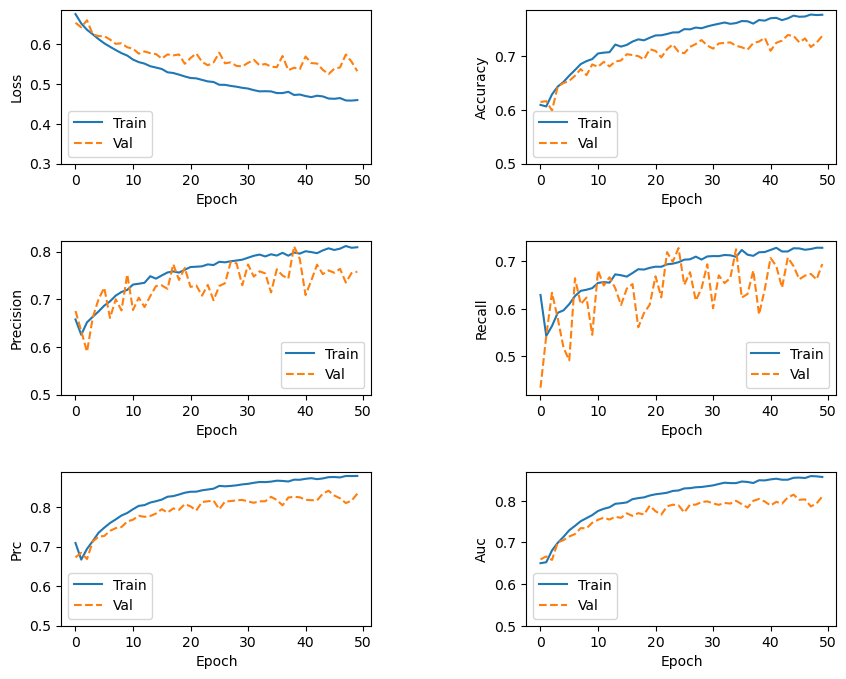

In [47]:
plot_metrics(resampled_history)


## evaluate metrics

In [48]:
y_train_pred_resampled = resampled_model.predict(x_train_resampled,batch_size=BATCH_SIZE)
y_test_pred_resampled = resampled_model.predict(x_test_resampled,batch_size=BATCH_SIZE)

619/619 [==============================] - 0s 599us/step


loss :  0.5492171049118042
tp :  1627.0
fp :  542.0
tn :  1975.0
fn :  802.0
accuracy :  0.7282652854919434
precision :  0.7501152753829956
recall :  0.6698229908943176
auc :  0.7959793210029602
prc :  0.8183050155639648

Legitimate Transactions Detected (True Negatives):  1975
Legitimate Transactions Incorrectly Detected (False Positives):  542
Fraudulent Transactions Missed (False Negatives):  802
Fraudulent Transactions Detected (True Positives):  1627
Total Fraudulent Transactions:  2429


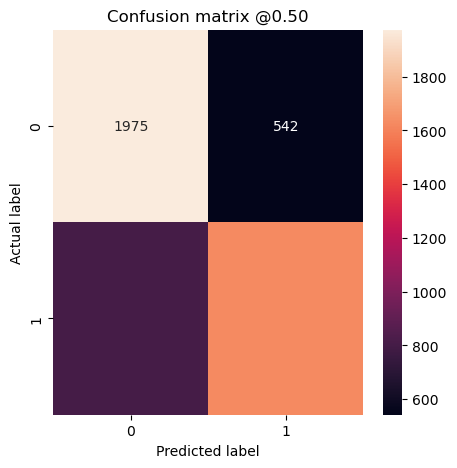

In [49]:
resampled_results = resampled_model.evaluate(x_test_resampled, y_test_resampled,batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test_resampled, y_test_pred_resampled)

## plot the ROC

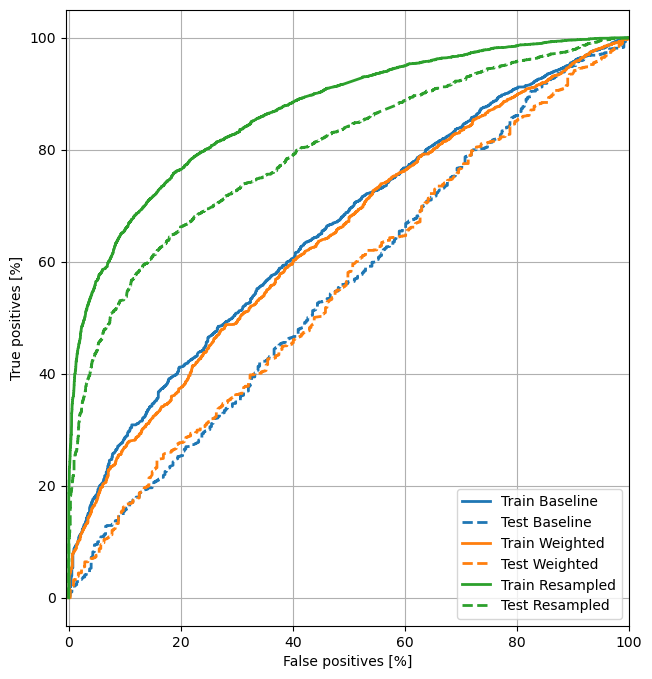

In [50]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", y_train_resampled, y_train_pred_resampled, color=colors[2])
plot_roc("Test Resampled", y_test_resampled, y_test_pred_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## plot the AUPRC

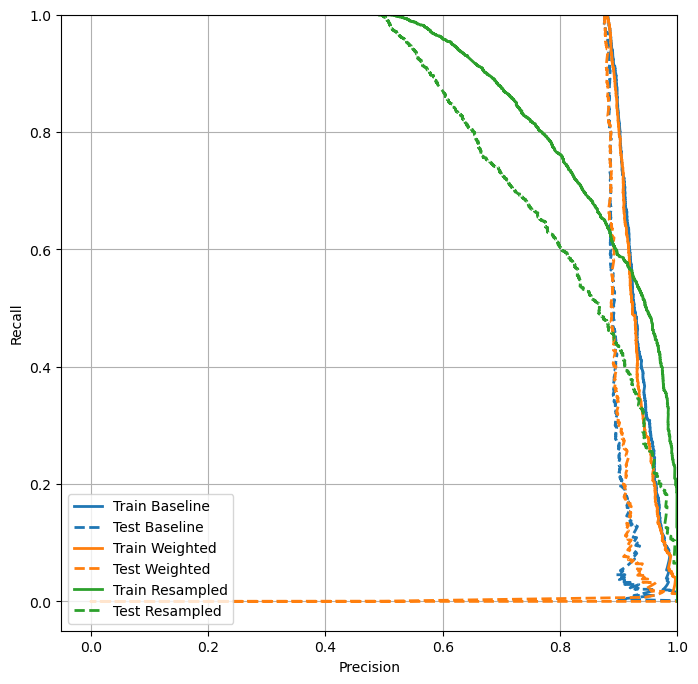

In [51]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train_resampled, y_train_pred_resampled, color=colors[2])
plot_prc("Test Resampled", y_test_resampled, y_test_pred_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower left')

## feature importance

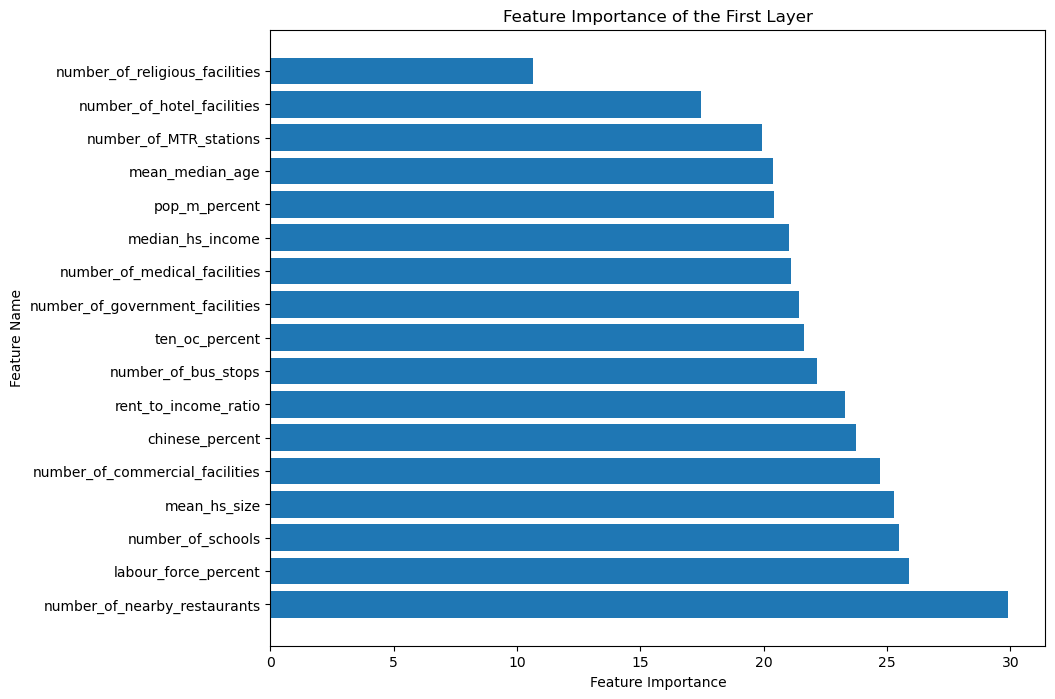

In [90]:
# get the weights of the first layer
weights = resampled_model.layers[0].get_weights()[0]

# calculate the feature importance
feature_importance = abs(weights).sum(axis=1)

# sort the feature importance in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_name = feature_name[sorted_indices]

# plot the feature importance(bar plot)
plt.figure(figsize=(10,8))
plt.barh(sorted_feature_name,sorted_feature_importance)
plt.yticks(range(len(sorted_feature_name)),sorted_feature_name)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance of the First Layer')
plt.show()



  1/155 [..............................] - ETA: 2s

155/155 [==============================] - 0s 589us/step


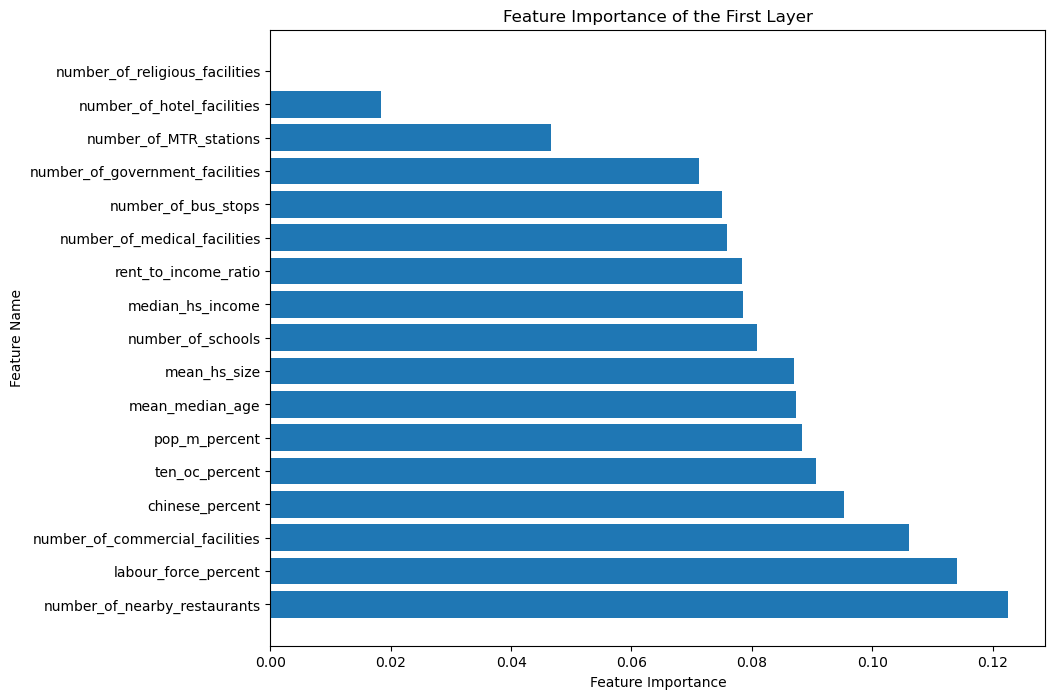

In [108]:
def score(x,y):
    y_pred = resampled_model.predict(x)
    return accuracy_score(y,y_pred>0.5)

base_score,score_decrease = get_score_importances(score,x_test_resampled.values,y_test_resampled.values,random_state=42)
feature_importance = np.mean(score_decrease,axis=0)

sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_name = feature_name[sorted_indices]

plt.figure(figsize=(10,8))
plt.barh(sorted_feature_name,sorted_feature_importance)
plt.yticks(range(len(sorted_feature_name)),sorted_feature_name)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance of the First Layer')
plt.show()


# save model

In [52]:
# check the existence of the save path
if not os.path.exists(save_path):
  os.makedirs(save_path)
# change the work path to save_path
os.chdir(save_path)
# save the model as json file
model_toJson = resampled_model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_toJson)
# serialize weights to HDF5
resampled_model.save_weights("model.h5")
# save as pkl file
joblib.dump(resampled_history,'model.pkl')
print('Model saved.')

Model saved.
